In [3]:
import pandas as pd
import numpy as np
import os
import sumolib
import copy
import json
from tqdm import tqdm
from datetime import datetime

In [4]:
m = 105
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
fmins = range(midnight, next_day, 300)

# 현재시각
present_time = fmins[m]
sim_start = fmins[m] - 300
# network and dataframes
net = sumolib.net.readNet('../Data/networks/sn.net.xml')
inter_node = pd.read_csv('../Data/tables/inter_node.csv', index_col=0)
plan = pd.read_csv('../Data/tables/plan.csv', index_col=0)
match6 = pd.read_csv('../Intermediates/match6.csv', index_col=0)
match6 = match6[['node_id', 'phase_no', 'ring_type', 'inc_edge', 'out_edge']].reset_index(drop=True)
histid = pd.read_csv(f'../Intermediates/histid/histid_{present_time}.csv', index_col=0)
histid = histid.reset_index(drop=True).drop(columns=['inter_no'])

# helper dictionaries and lists
inter_node_p = inter_node[inter_node.inter_type=='parent']
inter2node = dict(zip(inter_node_p['inter_no'], inter_node_p['node_id']))
node2inter = dict(zip(inter_node['node_id'], inter_node['inter_no']))
pa2ch = {'i0':['u00'], 'i1':[], 'i2':['u20'], 'i3':['c30', 'u30', 'u31', 'u32'], 'i6':['u60'], 'i7':[], 'i8':[], 'i9':[]}
node_ids = sorted(inter_node.node_id.unique())
parent_ids = sorted(inter_node[inter_node.inter_type=='parent'].node_id.unique())
nodes = [net.getNode(node_id) for node_id in node_ids]

In [5]:
def attach_children(histid, match6, parent_ids, pa2ch):
    '''
    자식교차로에 대한 진입·진출 엣지 정보를 붙여주는 함수

    input :
    (1) histid
     - 각 교차로에 대한 (시작유닉스, A현시, B현시)별 현시시간, 진입·진출엣지
     - 부모교차로(주교차로)에 대해서만 값이 지정되어 있음
    (2) match6
     - (현시, 링)별 진입·진출엣지
     - 자식교차로(유턴 및 연동교차로)에 대해서도 값이 지정되어 있음
    (3) parent_ids : 부모교차로 목록
    (4) pa2ch : 각 부모교차로id를 부모교차로가 포함하고 있는 자식교차로들의 id들의 리스트로 대응시키는 딕셔너리

    output : histids
     - 모든(부모 및 자식) 교차로에 대한 시작유닉스 (시작유닉스, A현시, B현시)별 현시시간, 진입·진출엣지
    '''
    new_histids = []
    for parent_id in parent_ids:
        for child_id in pa2ch[parent_id]:
            new_histid = histid.copy()[histid.node_id==parent_id]
            new_histid[['inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']] = np.nan
            for i, row in new_histid.iterrows():
                phas_A = row.phas_A
                phas_B = row.phas_B
                new_match = match6[match6.node_id==child_id]
                Arow = new_match[(new_match.phase_no==phas_A) & (new_match.ring_type=='A')]
                if ~ Arow[['inc_edge', 'out_edge']].isna().all().all():
                    inc_edge = Arow.iloc[0].inc_edge
                    out_edge = Arow.iloc[0].out_edge
                    new_histid.loc[i, ['inc_edge_A', 'out_edge_A']] = [inc_edge, out_edge]
                Brow = new_match[(new_match.phase_no==phas_B) & (new_match.ring_type=='B')]
                if ~ Brow[['inc_edge', 'out_edge']].isna().all().all():
                    inc_edge = Brow.iloc[0].inc_edge
                    out_edge = Brow.iloc[0].out_edge
                    new_histid.loc[i, ['inc_edge_B', 'out_edge_B']] = [inc_edge, out_edge]
                new_histid.loc[i, 'node_id'] = child_id
            new_histids.append(new_histid)
    new_histids = pd.concat(new_histids)
    histids = pd.concat([histid.copy(), new_histids])
    histids = histids.sort_values(by=['start_unix', 'node_id', 'phas_A', 'phas_B']).reset_index(drop=True)
    return histids
histids = attach_children(histid, match6, parent_ids, pa2ch)

In [6]:
def initialize_states(net, nodes, histids):
    '''
    신호 초기화

    input :
    (1) net : 네트워크
    (2) nodes : 노드 목록
    (3) histids : 모든 교차로에 대한 시작유닉스 (시작유닉스, A현시, B현시)별 현시시간, 진입·진출엣지

    output : node2init
     - 각 노드를 초기화된 신호로 맵핑하는 딕셔너리
     - 초기화된 신호란, 우회전을 g로 나머지는 r로 지정한 신호를 말함.
    '''
    node2init = {}
    for node in nodes:
        node_id = node.getID()
        conns = [(c.getJunctionIndex(), c) for c in node.getConnections()]
        conns = [c for c in conns if c[0] >= 0]
        conns = sorted(conns, key=lambda x: x[0])
        state = []
        for i, ci in conns:
            if ci.getTLLinkIndex() < 0:
                continue
            are_foes = False
            for j, cj in conns:
                if ci.getTo() == cj.getTo():
                    continue
                if node.areFoes(i, j):
                    are_foes = True
                    break
            state.append('r' if are_foes else 'g')
        node2init[node_id] = state

    # 어떤 연결과도 상충이 일어나지는 않지만, 신호가 부여되어 있는 경우에는 r을 부여
    for _, row in histids.iterrows():
        node_id = row['node_id']
        inc_edge_A = row.inc_edge_A
        inc_edge_B = row.inc_edge_B
        out_edge_A = row.out_edge_A
        out_edge_B = row.out_edge_B

        if pd.isna(inc_edge_A) or pd.isna(out_edge_A):
            pass
        else:
            inc_edge_A = net.getEdge(inc_edge_A)
            out_edge_A = net.getEdge(out_edge_A)
            for conn in inc_edge_A.getConnections(out_edge_A):
                index = conn.getTLLinkIndex()
                if index >= 0:
                    node2init[node_id][index] = 'r'

        if pd.isna(inc_edge_B) or pd.isna(out_edge_B):
            pass
        else:
            inc_edge_B = net.getEdge(inc_edge_B)
            out_edge_B = net.getEdge(out_edge_B)
            for conn in inc_edge_B.getConnections(out_edge_B):
                index = conn.getTLLinkIndex()
                if index >= 0:
                    node2init[node_id][index] = 'r'
    return node2init
node2init = initialize_states(net, nodes, histids)

In [7]:
def assign_signals(histids, node2init, net):
    '''
    진입·진출엣지를 신호문자열로 배정

    input :
    (1) histids : 모든 교차로에 대한 (시작유닉스, A현시, B현시)별 현시시간, 진입·진출엣지
    (2) node2init : 각 노드를 초기화된 신호로 맵핑하는 딕셔너리
    (3) net : 네트워크

    output : sigtable
     - 모든 교차로에 대한 (시작유닉스, A현시, B현시)별 현시시간, 신호문자열
     - 황색 및 적색신호는 아직 반영되지 않았음.
    '''
    sigtable = histids.copy()
    sigtable['init_state'] = sigtable['node_id'].map(node2init)
    sigtable['state'] = sigtable['init_state'].map(lambda x:''.join(x))
    for i, row in sigtable.iterrows():
        node_id = row.node_id
        inc_edge_A = row.inc_edge_A
        inc_edge_B = row.inc_edge_B
        out_edge_A = row.out_edge_A
        out_edge_B = row.out_edge_B
        state = copy.deepcopy(node2init)[node_id]
        if pd.isna(inc_edge_A) or pd.isna(out_edge_A):
            pass
        else:
            inc_edge_A = net.getEdge(inc_edge_A)
            out_edge_A = net.getEdge(out_edge_A)
            for conn in inc_edge_A.getConnections(out_edge_A):
                index = conn.getTLLinkIndex()
                if index >= 0:
                    state[index] = 'G'
            sigtable.at[i, 'state'] = ''.join(state)

        if pd.isna(inc_edge_B) or pd.isna(out_edge_B):
            pass
        else:
            inc_edge_B = net.getEdge(inc_edge_B)
            out_edge_B = net.getEdge(out_edge_B)
            for conn in inc_edge_B.getConnections(out_edge_B):
                index = conn.getTLLinkIndex()
                if index >= 0:
                    state[index] = 'G'
            sigtable.at[i, 'state'] = ''.join(state)
    sigtable = sigtable.dropna(subset='state')
    sigtable = sigtable.reset_index(drop=True)
    sigtable['phase_sumo'] = sigtable.groupby(['node_id', 'start_unix']).cumcount()
    sigtable = sigtable[['node_id', 'start_unix', 'phase_sumo', 'duration', 'state']]
    sigtable = sigtable.sort_values(by=['start_unix', 'node_id'])
    sigtable['start_dt'] = sigtable['start_unix'].apply(lambda x:datetime.fromtimestamp(x))
    return sigtable
sigtable = assign_signals(histids, node2init, net)

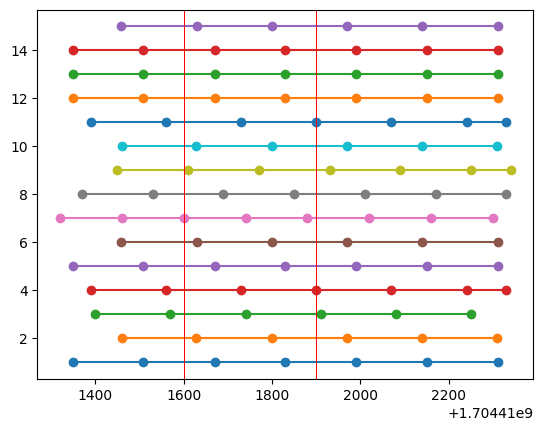

In [8]:
import matplotlib.pyplot as plt
k = 0
for node_id, group in sigtable.groupby('node_id'):
    k += 1
    plt.plot(group.start_unix.unique(), [k] * len(group.start_unix.unique()), marker='o')
    plt.axvline(present_time - 300, c='r', linewidth=.5)
    plt.axvline(present_time, c='r', linewidth=.5)

In [9]:
# node2num_cycles : A dictionary that maps a node_id to the number of cycles
def get_node2num_cycles(plan, node_ids):
    Aplan = plan.copy()[['inter_no'] + [f'dura_A{j}' for j in range(1,9)] + ['cycle']]
    grouped = Aplan.groupby('inter_no')
    df = grouped.agg({'cycle': 'min'}).reset_index()
    df = df.rename(columns={'cycle': 'min_cycle'})
    df['num_cycle'] = 300 // df['min_cycle'] + 2
    inter2num_cycles = dict(zip(df['inter_no'], df['num_cycle']))
    node2numcycles = {node_id : inter2num_cycles[node2inter[node_id]] for node_id in node_ids}
    with open('../Intermediates/node2numcycles.json', 'w') as file:
        json.dump(node2numcycles, file, indent=4)
    return node2numcycles
node2num_cycles = get_node2num_cycles(plan, node_ids)
node2num_cycles

{'c30': 4,
 'i0': 3,
 'i1': 4,
 'i2': 4,
 'i3': 4,
 'i6': 4,
 'i7': 4,
 'i8': 4,
 'i9': 4,
 'u00': 3,
 'u20': 4,
 'u30': 4,
 'u31': 4,
 'u32': 4,
 'u60': 4}

In [10]:
def set_timepoints(sigtable, node2num_cycles, present_time):
    offsets = {}
    Sigtable = []
    sim_start = present_time - 300
    for node_id, group in sigtable.groupby('node_id'):
        lsbs = group[group['start_unix'] < sim_start]['start_unix'].max() # the last start_unix before sim_start
        offsets[node_id] = lsbs - sim_start
        group = group[group.start_unix >= lsbs]
        start_unixes = np.array(group.start_unix)
        start_unixes = np.sort(np.unique(start_unixes))[:node2num_cycles[node_id]]
        group = group[group.start_unix.isin(start_unixes)]
        Sigtable.append(group)
    Sigtable = pd.concat(Sigtable)
    return Sigtable, offsets
Sigtable, offsets = set_timepoints(sigtable, node2num_cycles, present_time)

In [11]:
node2num_cycles

{'c30': 4,
 'i0': 3,
 'i1': 4,
 'i2': 4,
 'i3': 4,
 'i6': 4,
 'i7': 4,
 'i8': 4,
 'i9': 4,
 'u00': 3,
 'u20': 4,
 'u30': 4,
 'u31': 4,
 'u32': 4,
 'u60': 4}

1 c30 4
2 i0 3
3 i1 4
4 i2 4
5 i3 4
6 i6 4
7 i7 4
8 i8 4
9 i9 4
10 u00 3
11 u20 4
12 u30 4
13 u31 4
14 u32 4
15 u60 4


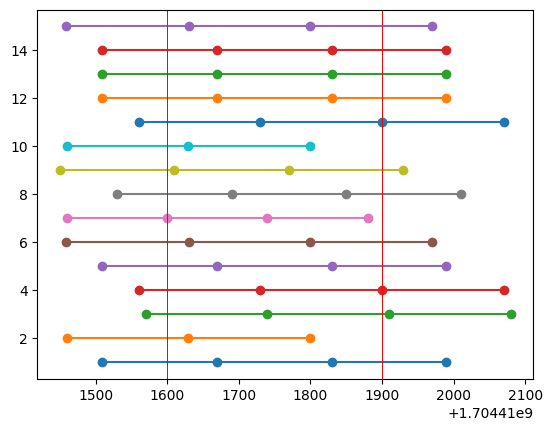

In [12]:
import matplotlib.pyplot as plt
k = 0
for node_id, group in Sigtable.groupby('node_id'):
    k += 1
    print(k, node_id, node2num_cycles[node_id])
    plt.plot(group.start_unix.unique(), [k] * len(group.start_unix.unique()), marker='o')
    plt.axvline(present_time - 300, c='r', linewidth=.5)
    plt.axvline(present_time, c='r', linewidth=.5)

In [13]:
display(sigtable)
display(Sigtable)

node_id  start_unix  phase_sumo  duration    state            start_dt
0        i7  1704411320           0        44  GGrggGG 2024-01-05 08:35:20
1        i7  1704411320           1        44  rrrggrr 2024-01-05 08:35:20
2        i7  1704411320           2        26  GGrggGG 2024-01-05 08:35:20
3        i7  1704411320           3        26  rrrggrr 2024-01-05 08:35:20
4       c30  1704411350           0        38   rrrrrr 2024-01-05 08:35:50
..      ...         ...         ...       ...      ...                 ...
410     u20  1704412330           1        13   ggrggg 2024-01-05 08:52:10
411     u20  1704412330           2        38   ggGggg 2024-01-05 08:52:10
412     u20  1704412330           3        18   ggrggg 2024-01-05 08:52:10
413      i9  1704412340           0        26     GGGG 2024-01-05 08:52:20
414      i9  1704412340           1        64     rrrr 2024-01-05 08:52:20

[415 rows x 6 columns]

node_id  start_unix  phase_sumo  duration      state            start_dt
66      c30  1704411509           0        38     rrrrrr 2024-01-05 08:38:29
67      c30  1704411509           1        39     GGGGGG 2024-01-05 08:38:29
68      c30  1704411509           2        41     GGGGGG 2024-01-05 08:38:29
69      c30  1704411509           3        21     GGGGGG 2024-01-05 08:38:29
128     c30  1704411670           0        38     rrrrrr 2024-01-05 08:41:10
..      ...         ...         ...       ...        ...                 ...
247     u60  1704411970           0        24  ggggggggr 2024-01-05 08:46:10
248     u60  1704411970           1        19  ggggggggr 2024-01-05 08:46:10
249     u60  1704411970           2        39  ggggggggG 2024-01-05 08:46:10
250     u60  1704411970           3        65  ggggggggr 2024-01-05 08:46:10
251     u60  1704411970           4        23  ggggggggr 2024-01-05 08:46:10

[238 rows x 6 columns]

In [14]:
def assign_red_yellow(Sigtable):
    '''
    적색, 황색신호를 반영한 신호문자열 배정

    input : Sigtable
    - 모든 교차로에 대한 (시작유닉스, 세부현시번호)별 현시시간, 신호문자열, 진입·진출엣지
    * 세부현시란 오버랩을 반영한 현시번호를 뜻함.

    output : SIGTABLE
    - 모든 교차로에 대한 (시작유닉스, 녹황적세부현시번호)별 현시시간, (황·적색신호가 포함된) 신호문자열
    * 녹황적세부현시번호란 세부현시번호에 r, g, y 옵션까지 포함된 현시번호를 뜻함.
    '''
    SIGTABLE = []
    for node_id, group in Sigtable.groupby('node_id'):
        new_rows_list = []
        for i in range(1, len(group)):
            prev_row = group.iloc[i-1:i].copy()
            next_row = group.iloc[i:i+1].copy()
            new_rows = pd.concat([prev_row, prev_row, next_row]).reset_index(drop=True)
            new_rows.loc[0, 'phase_sumo'] = str(prev_row.phase_sumo.iloc[0]) + '_g'
            new_rows.loc[0, 'duration'] = new_rows.loc[0, 'duration'] - 5
            new_rows.loc[1, 'phase_sumo'] = str(prev_row.phase_sumo.iloc[0]) + '_y'
            new_rows.loc[1, 'duration'] = 4
            yellow_state = ''
            red_state = ''
            for a, b in zip(prev_row.state.iloc[0], next_row.state.iloc[0]):
                if a == 'G' and b == 'r':
                    yellow_state += 'y'
                    red_state += 'r'
                else:
                    yellow_state += a
                    red_state += a
            new_rows.loc[2, 'phase_sumo'] = str(next_row.phase_sumo.iloc[0]) + '__r'
            new_rows.loc[2, 'duration'] = 1
            new_rows.loc[1, 'state'] = yellow_state
            new_rows.loc[2, 'state'] = red_state
            new_rows_list.append(new_rows)
        next_row['phase_sumo'] = str(next_row.phase_sumo.iloc[0]) + '_g'
        next_row['duration'] -= 5
        # next_row.loc['duration'] -= 5
        new_rows_list.append(next_row)
        new_rows = pd.concat(new_rows_list)
        SIGTABLE.append(new_rows)
    SIGTABLE = pd.concat(SIGTABLE).sort_values(by=['node_id', 'start_unix', 'phase_sumo']).reset_index(drop=True)
    return SIGTABLE
SIGTABLE = assign_red_yellow(Sigtable)

In [26]:
max_unix, min_unix = int(datetime(2020, 1, 1).timestamp()), int(datetime(2038, 1, 1).timestamp())
print(max_unix)
print(min_unix)
history = pd.read_csv('../Data/tables/history.csv', index_col=0)
K = 0
for _, row in history.iterrows():
    unixbool = min_unix <= row['end_unix'] <= max_unix
    print(min_unix, row['end_unix'], max_unix)
    if not unixbool:
        K += 1
print(K)
print(len(history))

1577804400
2145884400
4021
4021


In [13]:
SIGTABLE[100:120]

node_id  start_unix phase_sumo  duration       state            start_dt
100      i1  1704411740       1__r         1  grrGGGrgrr 2024-01-05 08:42:20
101      i1  1704411740        1_g        88  grrGGGGgrr 2024-01-05 08:42:20
102      i1  1704411740        1_y         4  grryyyygrr 2024-01-05 08:42:20
103      i1  1704411740       2__r         1  grrrrrrgrr 2024-01-05 08:42:20
104      i1  1704411740        2_g        35  grrrrrrgGG 2024-01-05 08:42:20
105      i1  1704411740        2_y         4  grrrrrrgyy 2024-01-05 08:42:20
106      i1  1704411910       0__r         1  grrrrrrgrr 2024-01-05 08:45:10
107      i1  1704411910        0_g        32  gGGGGGrgrr 2024-01-05 08:45:10
108      i1  1704411910        0_y         4  gyyGGGrgrr 2024-01-05 08:45:10
109      i1  1704411910       1__r         1  grrGGGrgrr 2024-01-05 08:45:10
110      i1  1704411910        1_g        88  grrGGGGgrr 2024-01-05 08:45:10
111      i1  1704411910        1_y         4  grryyyygrr 2024-01-05 08:45:10
112      i1  1704411910       2__r         1  grrrrrrgrr 2024-01-05 08:45:10
113      i1  1704411910        2_g        35  grrrrrrgGG 2024-01-05 08:45:10
114      i1  1704411910        2_y         4  grrrrrrgyy 2024-01-05 08:45:10
115      i1  1704412080       0__r         1  grrrrrrgrr 2024-01-05 08:48:00
116      i1  1704412080        0_g        32  gGGGGGrgrr 2024-01-05 08:48:00
117      i1  1704412080        0_y         4  gyyGGGrgrr 2024-01-05 08:48:00
118      i1  1704412080       1__r         1  grrGGGrgrr 2024-01-05 08:48:00
119      i1  1704412080        1_g        88  grrGGGGgrr 2024-01-05 08:48:00

In [14]:
def make_tl_file(SIGTABLE, offsets, present_time):
    strings = ['<additional>\n']
    for node_id, group in SIGTABLE.groupby('node_id'):
        strings.append(f'    <tlLogic id="{node_id}" type="static" programID="{node_id}_prog" offset="{offsets[node_id]}">\n')
        for i, row in group.iterrows():
            duration = row.duration
            state = row.state
            strings.append(f'      <phase duration="{duration}" state="{state}"/>\n')
        strings.append('    </tlLogic>\n')
    strings.append('</additional>')
    strings = ''.join(strings)
    # 저장
    path_output = f'../Results/sn_{present_time}.add.xml'
    with open(path_output, 'w') as f:
        f.write(strings)

In [15]:
def generate_signals(m):
    midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
    next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
    fmins = range(midnight, next_day, 300)

    # 현재시각
    present_time = fmins[m]
    sim_start = fmins[m] - 300
    
    # network and dataframes
    net = sumolib.net.readNet('../Data/networks/sn.net.xml')
    inter_node = pd.read_csv('../data/tables/inter_node.csv', index_col=0)
    plan = pd.read_csv('../Data/tables/plan.csv', index_col=0)
    match6 = pd.read_csv('../Intermediates/match6.csv', index_col=0)
    match6 = match6[['node_id', 'phase_no', 'ring_type', 'inc_edge', 'out_edge']].reset_index(drop=True)
    histid = pd.read_csv(f'../Intermediates/histid/histid_{present_time}.csv', index_col=0)
    histid = histid.reset_index(drop=True).drop(columns=['inter_no'])
    
    # helper dictionaries and lists
    inter_node_p = inter_node[inter_node.inter_type=='parent']
    inter2node = dict(zip(inter_node_p['inter_no'], inter_node_p['node_id']))
    node2inter = dict(zip(inter_node['node_id'], inter_node['inter_no']))
    pa2ch = {'i0':['u00'], 'i1':[], 'i2':['u20'], 'i3':['c30', 'u30', 'u31', 'u32'], 'i6':['u60'], 'i7':[], 'i8':[], 'i9':[]}
    node_ids = sorted(inter_node.node_id.unique())
    parent_ids = sorted(inter_node[inter_node.inter_type=='parent'].node_id.unique())
    nodes = [net.getNode(node_id) for node_id in node_ids]

    # histids
    histids = attach_children(histid, match6, parent_ids, pa2ch)

    # node2init
    node2init = initialize_states(net, nodes, histids)

    # sigtable
    sigtable = assign_signals(histids, node2init, net)

    with open('../Intermediates/node2numcycles.json', 'r') as file:
        node2numcycles = json.load(file)

    # Sigtable
    Sigtable, offsets = set_timepoints(sigtable, node2num_cycles, present_time)

    # SIGTABLE
    SIGTABLE = assign_red_yellow(Sigtable)

    make_tl_file(SIGTABLE, offsets, present_time)
    print(f'A signal file (add.xml) has been created for the timeslot between {datetime.fromtimestamp(sim_start)} and {datetime.fromtimestamp(present_time)} ({sim_start} ~ {present_time})')

In [16]:
generate_signals(105)
generate_signals(106)

A signal file (add.xml) has been created for the timeslot between 2024-01-05 08:40:00 and 2024-01-05 08:45:00 (1704411600 ~ 1704411900)
A signal file (add.xml) has been created for the timeslot between 2024-01-05 08:45:00 and 2024-01-05 08:50:00 (1704411900 ~ 1704412200)
